# PulmoScope

**A Comparative Study of Hybrid TCN-SNN and Temporal Deep Learning Models for Multi-Class Respiratory Disease Detection from Lung Auscultation Sounds**
***Felisilda, G., Menorias, N., Olaguir, K.M., Santos, J.R.*** 

*Access full manuscipt here:*
https://drive.google.com/drive/folders/1OlAja6vAtOdrsXqGAM3bAAIukLFxHemb?usp=sharing

## **Configurations**

### **Environment Setup & Configuration**
* **Imports & Reproducibility:** Loads essential libraries for deep learning (PyTorch, Lightning), audio analysis (Librosa), and spiking neural networks (SpikingJelly). Global random seeds are fixed at `42` to ensure reproducible experiments.
* **Hyperparameters & Data Mapping:** Defines the `DEFAULT_CONFIG` for audio feature extraction (High-Res Mel-Spectrograms + MFCCs) and model training. It establishes a hyperparameter grid (`HP_GRID`) for tuning and simplifies the classification task by mapping rare respiratory conditions (e.g., Asthma, LRTI) to a consolidated "Other" class.

In [ ]:
import sys
sys.setrecursionlimit(10000)

import os, glob, numpy as np, pandas as pd, librosa, torch, copy, time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint, TQDMProgressBar
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from spikingjelly.clock_driven import neuron, surrogate, functional
from tqdm.auto import tqdm
import kagglehub
import random
import itertools
import warnings
import cv2

# Try importing torchinfo for architecture visualization
try:
    from torchinfo import summary
    HAS_TORCHINFO = True
except ImportError:
    HAS_TORCHINFO = False

warnings.filterwarnings("ignore")

# ================= CONFIGURATION =================
SEED = 42
pl.seed_everything(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEFAULT_CONFIG = {
    "SAMPLE_RATE": 16000, 
    "DURATION": 5, 
    "N_MELS": 224,          # High-Res Mel Spectrogram
    "N_MFCC": 40,           # Stacked MFCCs
    "N_FFT": 2048, 
    "HOP_LENGTH": 512,
    "BATCH_SIZE": 16, 
    "EPOCHS": 30, 
    "LR": 1e-3, 
    "WEIGHT_DECAY": 1e-4,
    "HIDDEN_DIM": 192, 
    "DROPOUT": 0.2, 
    "GRAD_CLIP": 1.0, 
    "PATIENCE": 10,
    "OPTIMIZER": "AdamW", 
    "LABEL_SMOOTHING": 0.0
}
DEFAULT_CONFIG["SAMPLES_PER_TRACK"] = int(DEFAULT_CONFIG["SAMPLE_RATE"] * DEFAULT_CONFIG["DURATION"])
TOTAL_INPUT_CHANNELS = DEFAULT_CONFIG["N_MELS"] + DEFAULT_CONFIG["N_MFCC"]

# Grid Search Space
HP_GRID = {
    "BATCH_SIZE": [16],
    "LR": [5e-4, 1e-3],         
    "WEIGHT_DECAY": [1e-4],
    "OPTIMIZER": ["AdamW"],
    "LABEL_SMOOTHING": [0.0, 0.1],
    "DROPOUT": [0.15, 0.2, 0.25],
    "HIDDEN_DIM": [192]
}

TUNING_EPOCHS = 10
FINAL_EPOCHS = 50

TARGET_CLASSES = ["COPD", "Healthy", "Pneumonia", "Other"]
LABEL_MAP = {c: i for i, c in enumerate(TARGET_CLASSES)}

DISEASE_MAPPING = {
    'COPD': 'COPD', 'Healthy': 'Healthy', 'Pneumonia': 'Pneumonia',
    'Asthma': 'Other', 'LRTI': 'Other', 'Bronchiectasis': 'Other',
    'Bronchiolitis': 'Other', 'URTI': 'Other'
}

### **Data Pipeline & Explainability**
This section defines the end-to-end processing and interpretation logic.

* **Signal Processing:** `apply_bandpass_filter` isolates relevant lung frequencies (50-2500Hz), while `peak_normalize` scales amplitudes to a consistent range.
* **Feature Extraction:** `get_features` serves as the main pipeline: it loads audio, standardizes length (via loop-padding), and stacks normalized **Mel-Spectrograms + MFCCs** into a unified input tensor.
* **Augmentation & Loading:** `augment_spectrogram` implements Frequency Masking (SpecAugment) for training robustness. `AudioDataset` wraps the processed arrays for PyTorch DataLoaders.
* **Interpretability (GradCAM):** A custom `GradCAM` class is implemented to generate heatmaps, visualizing which specific time-frequency regions drive the model's predictions.

In [ ]:
# ================= DATA PREPARATION =================

def apply_bandpass_filter(data, lowcut=50, highcut=2500, fs=16000, order=5):
    """Removes heartbeats (<50Hz) and high-freq hiss (>2500Hz)"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.filtfilt(b, a, data)
    return y

def peak_normalize(y):
    if np.max(np.abs(y)) > 0: return y / np.max(np.abs(y))
    return y

def get_features(file_path, start_time=0, duration=None):
    try:
        if duration:
            y, sr = librosa.load(file_path, sr=DEFAULT_CONFIG["SAMPLE_RATE"], offset=start_time, duration=duration)
        else:
            y, sr = librosa.load(file_path, sr=DEFAULT_CONFIG["SAMPLE_RATE"])
        
        y = apply_bandpass_filter(y, fs=sr)
        y = peak_normalize(y)
        
        target_len = DEFAULT_CONFIG["SAMPLES_PER_TRACK"]
        current_len = len(y)
        if current_len > target_len: y = y[:target_len]
        elif current_len < target_len:
            num_repeats = int(np.ceil(target_len / current_len))
            y = np.tile(y, num_repeats)[:target_len]
            
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=DEFAULT_CONFIG["N_MELS"], 
                                           n_fft=DEFAULT_CONFIG["N_FFT"], hop_length=DEFAULT_CONFIG["HOP_LENGTH"])
        S_db = librosa.power_to_db(S, ref=np.max)
        S_norm = (S_db - S_db.mean()) / (S_db.std() + 1e-8)

        mfcc = librosa.feature.mfcc(S=S_db, n_mfcc=DEFAULT_CONFIG["N_MFCC"])
        mfcc_norm = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-8)

        return np.vstack((S_norm, mfcc_norm)).astype(np.float32)
    except: return None

def augment_spectrogram(spec):
    aug_spec = spec.copy()
    if spec.shape[0] > 20: 
        f = random.randint(5, 20)
        f0 = random.randint(0, spec.shape[0] - f)
        aug_spec[f0:f0+f, :] = 0
    return aug_spec

def plot_class_distribution(counts, title):
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=TARGET_CLASSES, y=counts, palette="viridis")
    plt.title(title); plt.ylabel("Count")
    for i, v in enumerate(counts): ax.text(i, v, str(v), ha='center', fontweight='bold')
    plt.show()

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

# --- GRAD-CAM ---
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        self.handles = []
        
        target_layer = None
        if hasattr(model, 'tcn3'): target_layer = model.tcn3.bn 
        elif hasattr(model, 'rnn'): target_layer = model.rnn
        elif hasattr(model, 'lstm'): target_layer = model.lstm
            
        if target_layer is not None:
            self.handles.append(target_layer.register_forward_hook(self.save_activation))
            self.handles.append(target_layer.register_full_backward_hook(self.save_gradient))

    def remove_hooks(self):
        for h in self.handles: h.remove()

    def save_activation(self, module, input, output):
        if isinstance(output, tuple): self.activations = output[0].permute(0, 2, 1)
        else: self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        if isinstance(grad_output, tuple):
            grad = grad_output[0]
            if grad.shape == self.activations.shape: self.gradients = grad
            else: self.gradients = grad.permute(0, 2, 1)
        else: self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx):
        self.model.eval()
        self.model.zero_grad()
        self.gradients = None; self.activations = None
        
        output = self.model(input_tensor.unsqueeze(0))
        score = output[0, class_idx]
        score.backward()
        
        if self.gradients is None or self.activations is None: return np.zeros((input_tensor.shape[1], 1))

        pooled_gradients = torch.mean(self.gradients, dim=2, keepdim=True)
        weighted_activations = self.activations * pooled_gradients
        heatmap = torch.mean(weighted_activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
        if np.max(heatmap) > 0: heatmap /= np.max(heatmap)
            
        heatmap = cv2.resize(heatmap.reshape(1, -1), (input_tensor.shape[1], 1))
        heatmap = np.tile(heatmap, (input_tensor.shape[0], 1))
        return heatmap

### **Model Architectures**
This section defines the comparative model suite. To ensure an **"Apples-to-Apples"** comparison, all models terminate with the exact same `create_deep_classifier` head (3-layer MLP with BatchNorm, GELU, and Dropout).

* **`MultiScaleTCNBlock`**: The feature extraction backbone. It uses parallel 1D convolutions with varying kernel sizes (3, 5, 7) to capture short and long-term temporal dependencies simultaneously.
* **`Model_TCN_SNN` (Proposed)**: A hybrid architecture. It processes features via stacked TCN blocks, converts them into spike trains using a **Parametric LIF Node** (SpikingJelly), and aggregates temporal information via non-linear attention.
* **`Model_Pure_TCN` (Ablation)**: Identical to the proposed model but removes the neuromorphic component. It uses standard analog activations and attention to isolate the specific impact of the SNN layer.
* **`Model_Vanilla_RNN` & `Model_LSTM` (Baselines)**: Standard sequential benchmarks using 3 stacked layers, classifying based on the final hidden state.

In [ ]:
# ================= MODEL ARCHITECTURES =================

def create_deep_classifier(hidden_dim, n_classes, dropout):
    """Shared Deep Classifier Head for Apples-to-Apples comparison"""
    return nn.Sequential(
        nn.Linear(hidden_dim, 128),
        nn.BatchNorm1d(128),
        nn.GELU(),
        nn.Dropout(dropout),
        
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.GELU(),
        nn.Dropout(dropout),
        
        nn.Linear(64, n_classes)
    )

class MultiScaleTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3,5,7], dilation=1, dropout=0.15):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels, k, padding=((k-1)//2)*dilation, dilation=dilation)
            for k in kernel_sizes
        ])
        total_out = out_channels * len(kernel_sizes)
        self.bn = nn.BatchNorm1d(total_out)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.residual = nn.Conv1d(in_channels, total_out, 1) if in_channels != total_out else nn.Identity()

    def forward(self, x):
        out = torch.cat([conv(x) for conv in self.convs], dim=1)
        out = self.bn(out)
        out = self.dropout(self.relu(out))
        res = self.residual(x)
        if res.size(2) != out.size(2): res = res[:, :, :out.size(2)]
        return out + res

class Model_TCN_SNN(nn.Module):
    def __init__(self, n_classes=4, dropout=0.2, hidden_dim=192, input_channels=128):
        super().__init__()
        self.tcn1 = MultiScaleTCNBlock(input_channels, 64, dilation=1, dropout=dropout) 
        self.tcn2 = MultiScaleTCNBlock(192, 64, dilation=2, dropout=dropout)
        self.tcn3 = MultiScaleTCNBlock(192, 64, dilation=4, dropout=dropout)
        self.snn_bn = nn.BatchNorm1d(hidden_dim)
        self.neuron = neuron.ParametricLIFNode(init_tau=2.0, surrogate_function=surrogate.ATan(), detach_reset=True)
        self.attn_fc = nn.Linear(hidden_dim, 1)
        # Deep Classifier
        self.classifier = create_deep_classifier(hidden_dim, n_classes, dropout)

    def forward(self, x):
        functional.reset_net(self)
        x = self.tcn3(self.tcn2(self.tcn1(x)))
        x = self.snn_bn(x)
        x_time = x.permute(2, 0, 1)
        spk_rec = []
        for t in range(x_time.size(0)):
            spk_rec.append(self.neuron(x_time[t]))
        spk = torch.stack(spk_rec, dim=0).permute(1, 2, 0)
        
        # Non-Linear Attention
        attn_in = spk.transpose(1, 2)
        scores = self.attn_fc(torch.tanh(attn_in)) 
        w = torch.softmax(scores, dim=1)
        return self.classifier((attn_in * w).sum(dim=1))

class Model_Pure_TCN(nn.Module):
    def __init__(self, n_classes=4, dropout=0.2, hidden_dim=192, input_channels=128):
        super().__init__()
        self.tcn1 = MultiScaleTCNBlock(input_channels, 64, dilation=1, dropout=dropout)
        self.tcn2 = MultiScaleTCNBlock(192, 64, dilation=2, dropout=dropout)
        self.tcn3 = MultiScaleTCNBlock(192, 64, dilation=4, dropout=dropout)
        self.attn_fc = nn.Linear(hidden_dim, 1)
        # Shared Deep Classifier
        self.classifier = create_deep_classifier(hidden_dim, n_classes, dropout)

    def forward(self, x):
        x = self.tcn3(self.tcn2(self.tcn1(x)))
        # Standard Attention
        x = x.transpose(1, 2)
        scores = self.attn_fc(torch.tanh(x)) 
        w = torch.softmax(scores, dim=1)
        return self.classifier((x * w).sum(dim=1))

class Model_Vanilla_RNN(nn.Module):
    def __init__(self, n_classes=4, dropout=0.2, hidden_dim=192, input_channels=128):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_channels, hidden_size=hidden_dim, num_layers=3, 
                          batch_first=True, dropout=dropout)
        self.classifier = create_deep_classifier(hidden_dim, n_classes, dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out, _ = self.rnn(x)
        return self.classifier(out[:, -1, :]) 

class Model_LSTM(nn.Module):
    def __init__(self, n_classes=4, dropout=0.2, hidden_dim=192, input_channels=128):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_dim, num_layers=3, 
                            batch_first=True, dropout=dropout)
        self.classifier = create_deep_classifier(hidden_dim, n_classes, dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.classifier(out[:, -1, :]) 

### **Training Engine (PyTorch Lightning)**
This section standardizes the training loop to ensure fair comparison across all model architectures.

* **`LitWrapper`**: Encapsulates the entire training lifecycle.
    * **Optimization**: configure `AdamW` (default) combined with a `CosineAnnealingWarmRestarts` scheduler to help the model escape local minima.
    * **Loss Function**: Uses `CrossEntropyLoss` with optional **Label Smoothing** to prevent overfitting.
    * **Monitoring**: Automatically calculates and logs batch-level accuracy and loss.

* **`MetricsCallback`**: A custom hook that aggregates epoch-level performance into a simple dictionary (`self.history`). This bypasses standard loggers (like TensorBoard) to allow for quick, direct plotting of learning curves within the notebook.

In [ ]:
# ================= LIGHTNING MODULE =================

class LitWrapper(pl.LightningModule):
    def __init__(self, model_class, n_classes, hp_config):
        super().__init__()
        self.model = model_class(
            n_classes=n_classes, 
            dropout=hp_config["DROPOUT"], 
            hidden_dim=hp_config["HIDDEN_DIM"],
            input_channels=TOTAL_INPUT_CHANNELS
        )
        self.hp = hp_config
        self.loss_fn = nn.CrossEntropyLoss(label_smoothing=self.hp["LABEL_SMOOTHING"])

    def forward(self, x): return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", (logits.argmax(1)==y).float().mean(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.log("val_loss", self.loss_fn(logits, y))
        self.log("val_acc", (logits.argmax(1)==y).float().mean())
    
    def configure_optimizers(self):
        if self.hp["OPTIMIZER"] == "AdamW":
            opt = torch.optim.AdamW(self.parameters(), lr=self.hp["LR"], weight_decay=self.hp["WEIGHT_DECAY"])
        elif self.hp["OPTIMIZER"] == "Adam":
            opt = torch.optim.Adam(self.parameters(), lr=self.hp["LR"], weight_decay=self.hp["WEIGHT_DECAY"])
        else:
            opt = torch.optim.AdamW(self.parameters(), lr=self.hp["LR"])
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10)
        return {"optimizer": opt, "lr_scheduler": sch}

class MetricsCallback(Callback):
    def __init__(self):
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    def on_train_epoch_end(self, trainer, pl_module):
        m = trainer.callback_metrics
        self.history['train_loss'].append(m.get('train_loss', 0).item())
        self.history['train_acc'].append(m.get('train_acc', 0).item())
    def on_validation_epoch_end(self, trainer, pl_module):
        if trainer.sanity_checking: return
        m = trainer.callback_metrics
        if 'val_loss' in m:
            self.history['val_loss'].append(m.get('val_loss').item())
            self.history['val_acc'].append(m.get('val_acc').item())

### **Visualization & Evaluation Tools**
These functions handle performance monitoring and model interpretability.

* **`select_fixed_samples`**: Freezes a small set of validation examples (3 per class) to ensure that GradCAM visualizations are generated on the exact same inputs across different models and epochs.
* **`plot_metrics_for_model`**: A comprehensive evaluation suite that renders the **Confusion Matrix** and **ROC-AUC Curves**, and prints the classification report.
* **`generate_explainer_plots`**: Wraps the GradCAM logic to produce side-by-side comparisons of the original Mel-Spectrogram input versus the model's attention heatmap.

In [ ]:
# ================= VISUALIZATION =================

def select_fixed_samples(loader, num_per_class=3):
    """Selects FIXED samples from the loader for persistent comparison"""
    samples = {i: [] for i in range(len(TARGET_CLASSES))}
    # Iterate through the entire loader to find enough samples
    for x, y in loader:
        for i in range(len(y)):
            label = y[i].item()
            if len(samples[label]) < num_per_class:
                samples[label].append(x[i])
        # Check if we have enough
        if all(len(v) >= num_per_class for v in samples.values()):
            break
    return samples

def get_random_hp():
    config = {}
    for key, values in HP_GRID.items():
        config[key] = random.choice(values)
    return config

def plot_phase1_convergence(history, name):
    min_len = min(len(history['train_loss']), len(history['val_loss']))
    epochs = range(1, min_len + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Phase 1 Search: {name} Convergence", fontsize=12)
    ax1.plot(epochs, history['train_acc'][:min_len], label='Train Acc', marker='.')
    ax1.plot(epochs, history['val_acc'][:min_len], label='Val Acc', marker='.')
    ax1.set_title("Accuracy"); ax1.legend(); ax1.grid(alpha=0.3)
    ax2.plot(epochs, history['train_loss'][:min_len], label='Train Loss', marker='.')
    ax2.plot(epochs, history['val_loss'][:min_len], label='Val Loss', marker='.')
    ax2.set_title("Loss"); ax2.legend(); ax2.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

def evaluate_on_set(model, loader, device="cpu"):
    model.eval(); model.to(device)
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for x, y_b in loader:
            x, y_b = x.to(device), y_b.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            y_true.extend(y_b.cpu().numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_probs)

def plot_metrics_for_model(name, y_true, y_pred, y_probs, title_suffix="(Phase 1)"):
    print(f"\n{'='*20} {name} EVALUATION {title_suffix} {'='*20}")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
                xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
    plt.title(f"{name} Confusion Matrix {title_suffix}")
    plt.show()

    plt.figure(figsize=(8, 6))
    y_bin = label_binarize(y_true, classes=range(len(TARGET_CLASSES)))
    colors = ['blue', 'green', 'red', 'purple']
    for i, c in enumerate(TARGET_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{c} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--'); plt.title(f"{name} ROC-AUC {title_suffix}"); 
    plt.legend(); 
    plt.grid(alpha=0.3); 
    plt.show()
    print(classification_report(y_true, y_pred, target_names=TARGET_CLASSES))

def generate_explainer_plots(model, fixed_samples, name):
    print(f"\nGenerating Grad-CAM Explainer for {name}...")
    model.eval()
    grad_cam = GradCAM(model)
    
    fig, axes = plt.subplots(len(TARGET_CLASSES), 6, figsize=(18, 12))
    fig.suptitle(f"{name}: Original Input vs Grad-CAM Explainer", fontsize=16)
    
    for row, c_idx in enumerate(range(len(TARGET_CLASSES))):
        samples = fixed_samples[c_idx]
        for sample_i in range(3):
            col_orig, col_sal = sample_i * 2, sample_i * 2 + 1
            if sample_i < len(samples):
                sample = samples[sample_i]
                heatmap = grad_cam.generate_heatmap(sample, c_idx)
                
                axes[row, col_orig].imshow(sample.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
                axes[row, col_orig].set_title("Input"); axes[row, col_orig].axis('off')
                
                axes[row, col_sal].imshow(heatmap, aspect='auto', origin='lower', cmap='hot')
                axes[row, col_sal].set_title("Grad-CAM"); axes[row, col_sal].axis('off')
            else:
                axes[row, col_orig].axis('off'); axes[row, col_sal].axis('off')
        
        axes[row, 0].text(-0.5, 0.5, TARGET_CLASSES[c_idx], transform=axes[row, 0].transAxes, 
                          fontsize=14, fontweight='bold', va='center', rotation=90)
    
    plt.tight_layout(); plt.show()
    grad_cam.remove_hooks()

def run_phase_1_architecture_search(models_dict, X_train, y_train, X_val, y_val):
    print("\n" + "="*60 + "\nPHASE 1: ARCHITECTURE SEARCH (Train All models 50 Epochs)\n" + "="*60)
    
    # 1. SETUP DATA
    t_loader = DataLoader(AudioDataset(X_train, y_train), batch_size=DEFAULT_CONFIG["BATCH_SIZE"], shuffle=True, num_workers=0)
    v_loader = DataLoader(AudioDataset(X_val, y_val), batch_size=DEFAULT_CONFIG["BATCH_SIZE"], num_workers=0)
    
    # 2. SELECT FIXED VALIDATION SAMPLES (APPLES-TO-APPLES EXPLAINER)
    fixed_val_samples = select_fixed_samples(v_loader)
    
    performance_records = [] 
    
    for name, model_cls in models_dict.items():
        print(f"\n{'='*20} Processing: {name} {'='*20}")
        lit_model = LitWrapper(model_cls, len(TARGET_CLASSES), DEFAULT_CONFIG)
        
        if HAS_TORCHINFO:
            print(f"\n[Model Architecture: {name}]")
            n_frames = int(DEFAULT_CONFIG["SAMPLES_PER_TRACK"] / DEFAULT_CONFIG["HOP_LENGTH"]) + 1
            summary(lit_model.model, input_size=(1, TOTAL_INPUT_CHANNELS, n_frames), col_names=["output_size", "num_params"])

        metrics_cb = MetricsCallback()
        start_t = time.time()
        trainer = pl.Trainer(
            max_epochs=DEFAULT_CONFIG["EPOCHS"], accelerator='auto', devices=1, gradient_clip_val=1.0,
            callbacks=[metrics_cb, EarlyStopping("val_loss", patience=DEFAULT_CONFIG["PATIENCE"]), TQDMProgressBar(refresh_rate=10)]
        )
        trainer.fit(lit_model, t_loader, v_loader)
        end_t = time.time()
        
        val_acc = max(metrics_cb.history['val_acc']) if metrics_cb.history['val_acc'] else 0.0
        print(f"\n>>> {name} Finished | Time: {end_t-start_t:.2f}s | Best Val Acc: {val_acc:.4f}")
        
        if len(metrics_cb.history['train_loss']) > 0:
            plot_phase1_convergence(metrics_cb.history, name)
        
        y_true, y_pred, y_probs = evaluate_on_set(lit_model.model, v_loader)
        plot_metrics_for_model(name, y_true, y_pred, y_probs, title_suffix="(Phase 1 Val)")
        
        # --- PHASE 1 EXPLAINER (Using Fixed Samples) ---
        generate_explainer_plots(lit_model.model, fixed_val_samples, f"{name} (Phase 1)")
        # -----------------------------------------------
        
        performance_records.append((name, val_acc))

    performance_records.sort(key=lambda x: x[1], reverse=True)
    top_2_names = [x[0] for x in performance_records[:2]]
    print(f"\n🏆 TOP 2 CANDIDATES: {top_2_names}")
    return top_2_names

def run_phase_2_tuning(winner_name, winner_cls, X_train, y_train, X_val, y_val):
    print("\n" + "-"*50 + f"\nPHASE 2: GRID SEARCH TUNING ({winner_name})\n" + "-"*50)
    best_hp_acc = 0.0
    best_config = DEFAULT_CONFIG.copy() 
    
    keys, values = zip(*HP_GRID.items())
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    print(f"Total Combinations to Test: {len(all_combinations)}")

    for i, trial_config in enumerate(tqdm(all_combinations, desc=f"Tuning {winner_name}")):
        t_loader = DataLoader(AudioDataset(X_train, y_train), batch_size=trial_config["BATCH_SIZE"], shuffle=True, num_workers=0)
        v_loader = DataLoader(AudioDataset(X_val, y_val), batch_size=trial_config["BATCH_SIZE"], num_workers=0)
        model = LitWrapper(winner_cls, len(TARGET_CLASSES), trial_config)
        trainer = pl.Trainer(max_epochs=TUNING_EPOCHS, accelerator='auto', devices=1, enable_progress_bar=False, logger=False)
        trainer.fit(model, t_loader, v_loader)
        val_acc = trainer.callback_metrics.get("val_acc", 0.0).item()
        
        if val_acc > best_hp_acc:
            best_hp_acc = val_acc
            best_config = trial_config
            print(f"   [New Best] Trial {i+1}: Acc={val_acc:.4f} | Config={trial_config}")
            
    print(f"✅ Best HPs for {winner_name}: {best_config}")
    return best_config

def run_phase_3_final_train(model_name, model_cls, best_hp, X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n" + "-"*50 + f"\nPHASE 3: FINAL TRAINING ({model_name} + Best HPs)\n" + "-"*50)
    t_loader = DataLoader(AudioDataset(X_train, y_train), batch_size=best_hp["BATCH_SIZE"], shuffle=True)
    v_loader = DataLoader(AudioDataset(X_val, y_val), batch_size=best_hp["BATCH_SIZE"])
    test_loader = DataLoader(AudioDataset(X_test, y_test), batch_size=best_hp["BATCH_SIZE"])
    lit_model = LitWrapper(model_cls, len(TARGET_CLASSES), best_hp)
    metrics_cb = MetricsCallback()
    trainer = pl.Trainer(
        max_epochs=DEFAULT_CONFIG["EPOCHS"], accelerator='auto', devices=1, gradient_clip_val=1.0,
        callbacks=[metrics_cb, EarlyStopping("val_loss", patience=DEFAULT_CONFIG["PATIENCE"]), TQDMProgressBar(refresh_rate=10)]
    )
    start_time = time.time()
    trainer.fit(lit_model, t_loader, v_loader)
    total_time = time.time() - start_time
    y_true, y_pred, y_probs = evaluate_on_set(lit_model.model, test_loader)
            
    return {
        "name": model_name, "history": metrics_cb.history, 
        "y_true": y_true, "y_pred": y_pred, "y_probs": y_probs,
        "time": total_time, "model": lit_model.model, "hp": best_hp,
        "X_test": X_test, "y_test": y_test
    }

def visualize_final_results_list(results_list, fixed_test_samples):
    for res in results_list:
        n = res['name']
        print(f"\n{'#'*30} VISUALIZING FINAL MODEL: {n} {'#'*30}")
        
        h = res['history']
        min_len = min(len(h['train_loss']), len(h['val_loss']))
        epochs = range(1, min_len + 1)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        fig.suptitle(f"Final Optimized Convergence: {n}", fontsize=14)
        ax1.plot(epochs, h['train_acc'][:min_len], label='Train', marker='.')
        ax1.plot(epochs, h['val_acc'][:min_len], label='Val', marker='.')
        ax1.set_title("Accuracy"); ax1.legend(); ax1.grid(alpha=0.3)
        ax2.plot(epochs, h['train_loss'][:min_len], label='Train', marker='.')
        ax2.plot(epochs, h['val_loss'][:min_len], label='Val', marker='.')
        ax2.set_title("Loss"); ax2.legend(); ax2.grid(alpha=0.3)
        plt.show()

        plot_metrics_for_model(n, res['y_true'], res['y_pred'], res['y_probs'], title_suffix="(Final Test Optimized)")
        generate_explainer_plots(res['model'], fixed_test_samples, f"{n} (Final Optimized)")

## **Implementation**

This block orchestrates the end-to-end experiment, from raw data ingestion to final model verification.

* **Data Ingestion & Merging:** Downloads and parses two diverse datasets integrating them into a unified format.
* **Strict Balancing Strategy:** To eliminate class bias, the pipeline identifies the minority class count, downsamples all other classes to match it, and then doubles the total dataset size via augmentation (Spectrogram Masking).
* **Stratified Split:** Partitions the balanced data into **60% Train, 20% Validation, and 20% Test**.
* **Automated Experiment Loop:**
    1.  **Rank (Phase 1):** Trains all 4 architectures to identify the **Top 2** candidates.
    2.  **Tune (Phase 2):** Performs Grid Search on the top candidates to find their optimal hyperparameters.
    3.  **Evaluate (Phase 3):** Retrains the optimized models on the full training set, evaluates them on the held-out Test Set, and generates the final comparative **GradCAM visualizations**.

Seed set to 42


--- Loading Data ---
--- Extracting Features ---


  0%|          | 0/7103 [00:00<?, ?it/s]

--- [3/6] Balancing Data ---
Final Balanced Shape: (2808, 264, 157) (2x 351 per class)


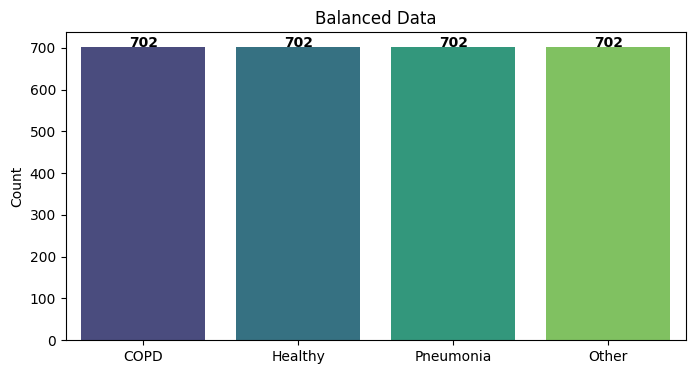


PHASE 1: ARCHITECTURE SEARCH (Train All models 50 Epochs)

==================== Processing: TCN-SNN ====================

[Model Architecture: TCN-SNN]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.



>>> TCN-SNN Finished | Time: 621.07s | Best Val Acc: 0.9359


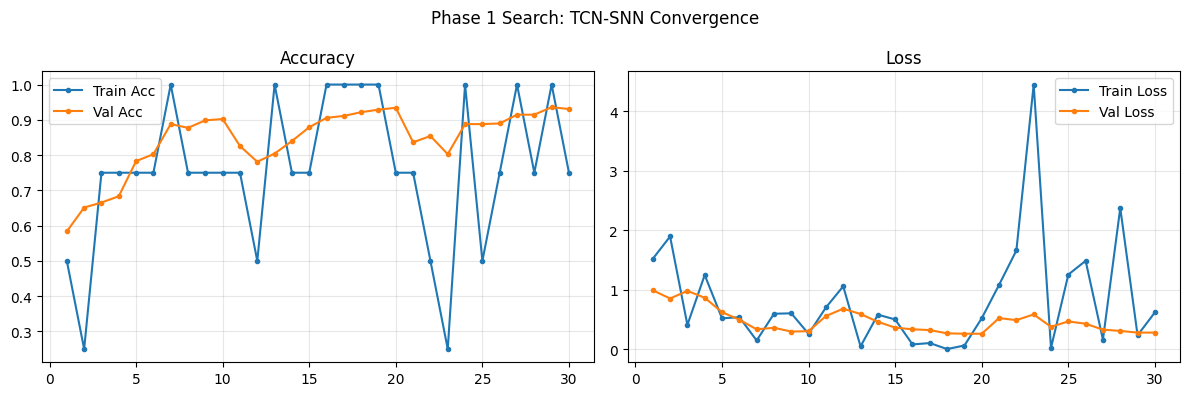


==================== TCN-SNN EVALUATION (Phase 1 Val) ====================


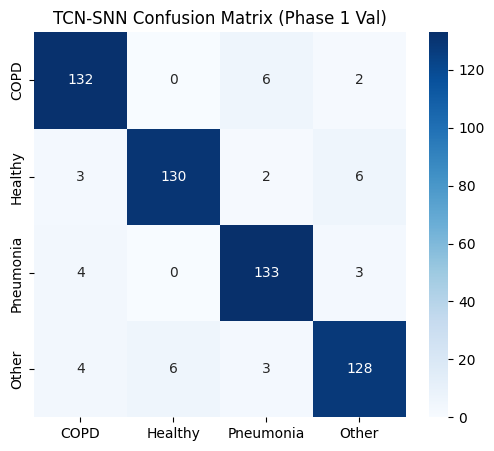

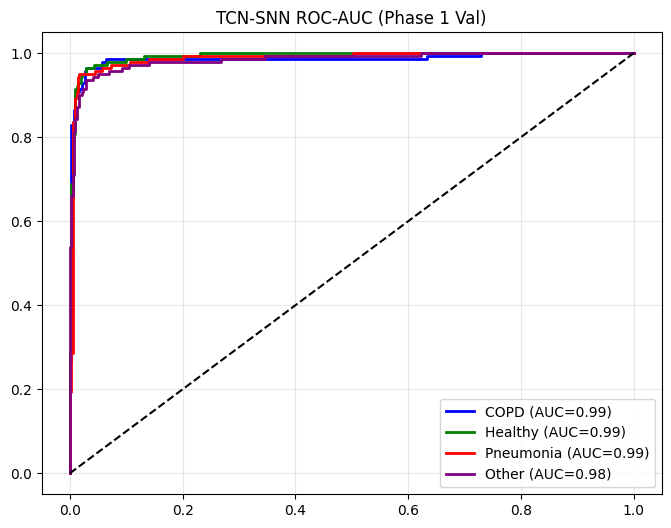

              precision    recall  f1-score   support

        COPD       0.92      0.94      0.93       140
     Healthy       0.96      0.92      0.94       141
   Pneumonia       0.92      0.95      0.94       140
       Other       0.92      0.91      0.91       141

    accuracy                           0.93       562
   macro avg       0.93      0.93      0.93       562
weighted avg       0.93      0.93      0.93       562


Generating Grad-CAM Explainer for TCN-SNN (Phase 1)...


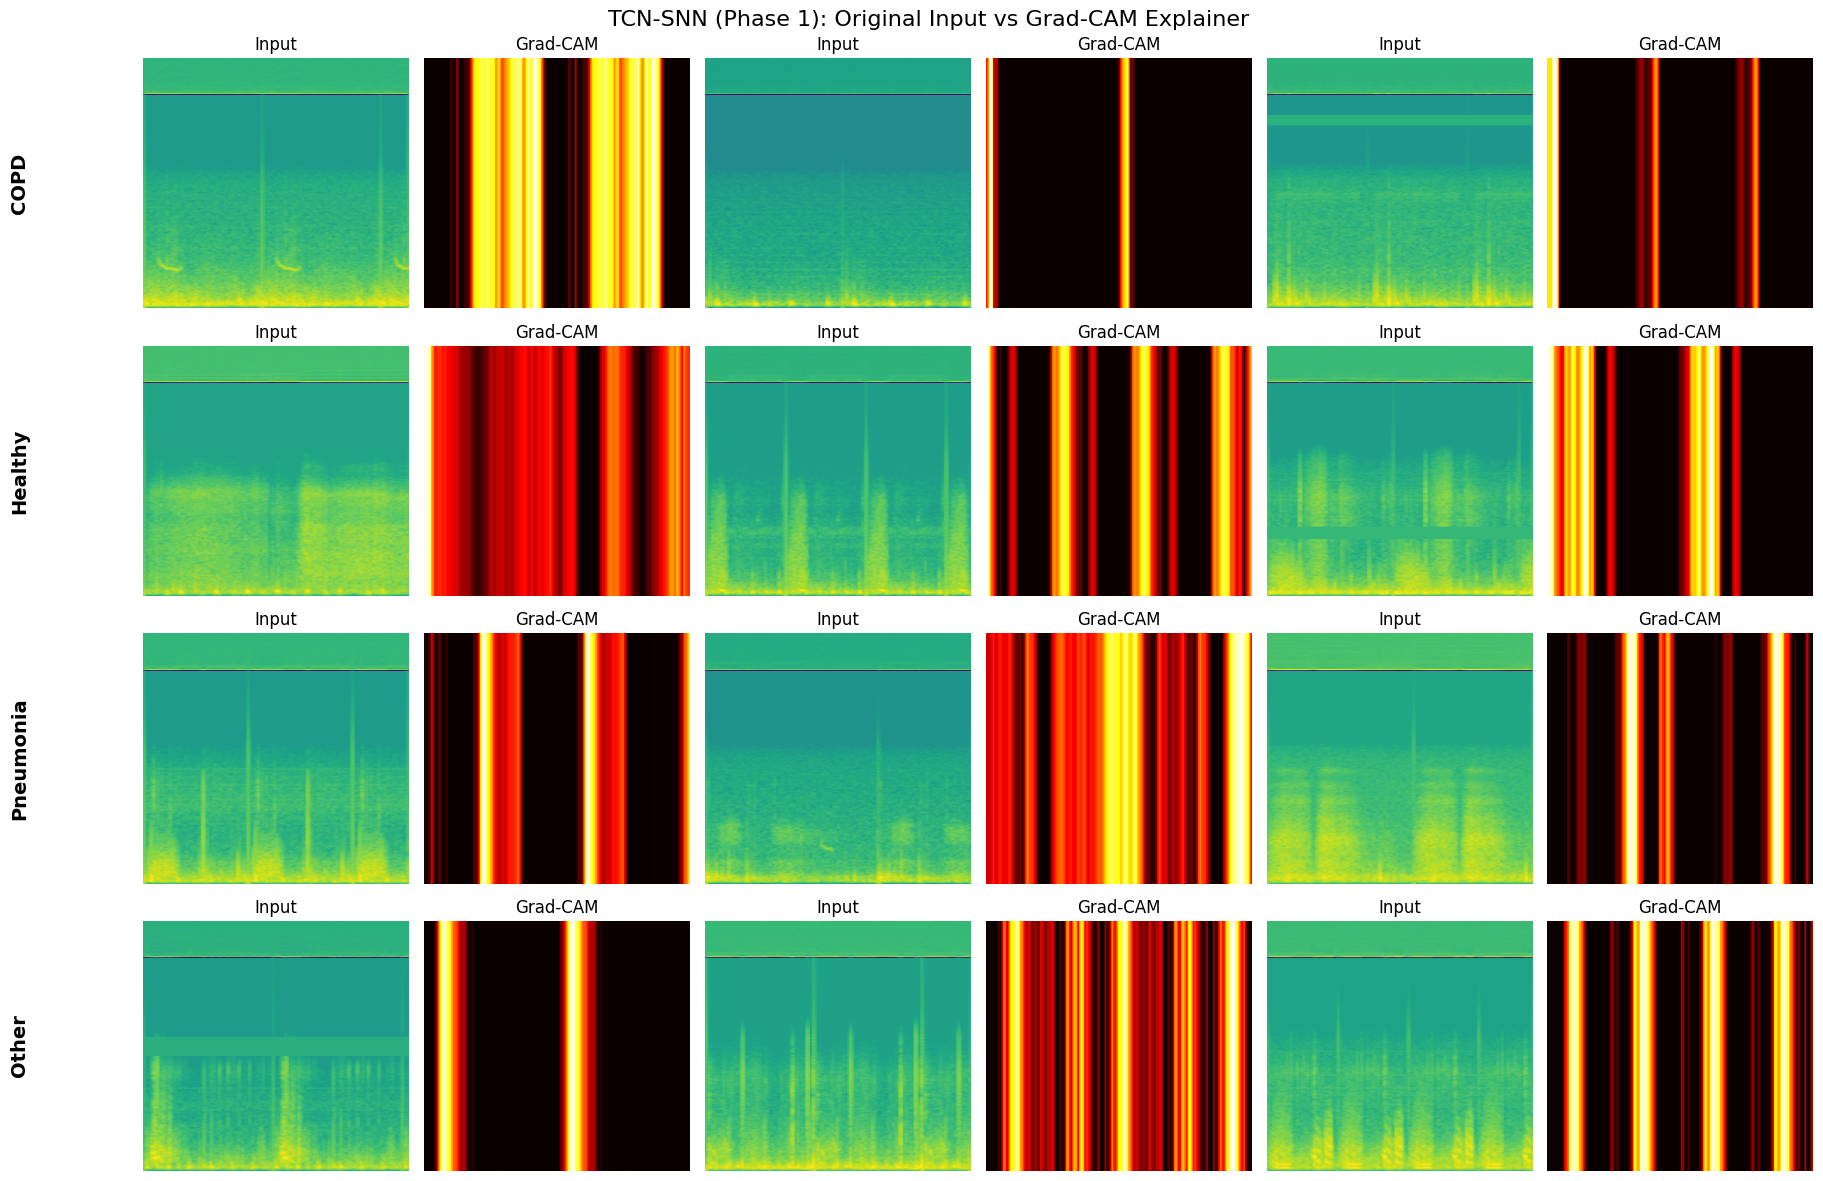

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



==================== Processing: Pure TCN ====================

[Model Architecture: Pure TCN]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.



>>> Pure TCN Finished | Time: 346.91s | Best Val Acc: 0.9395


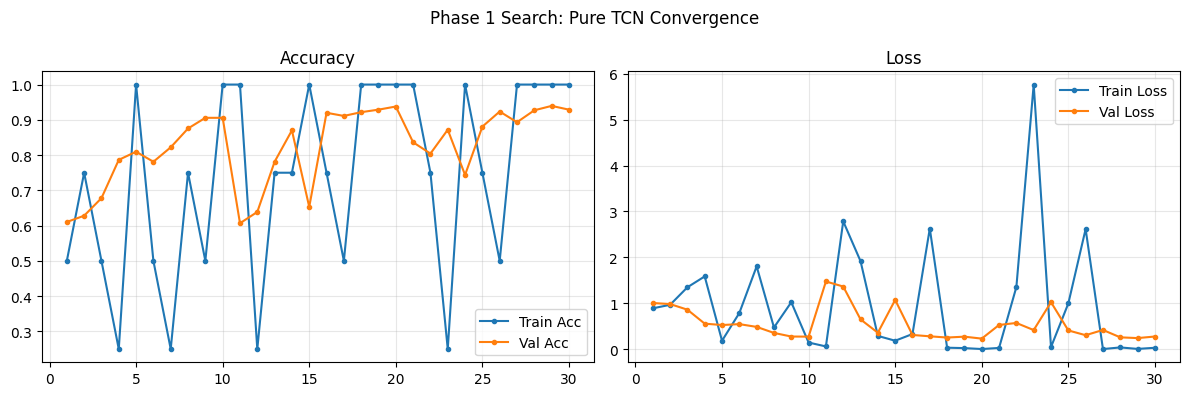


==================== Pure TCN EVALUATION (Phase 1 Val) ====================


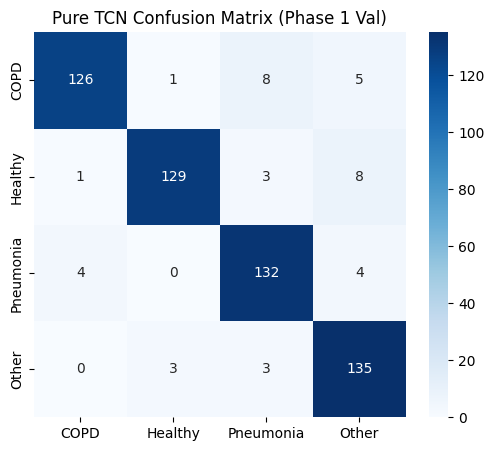

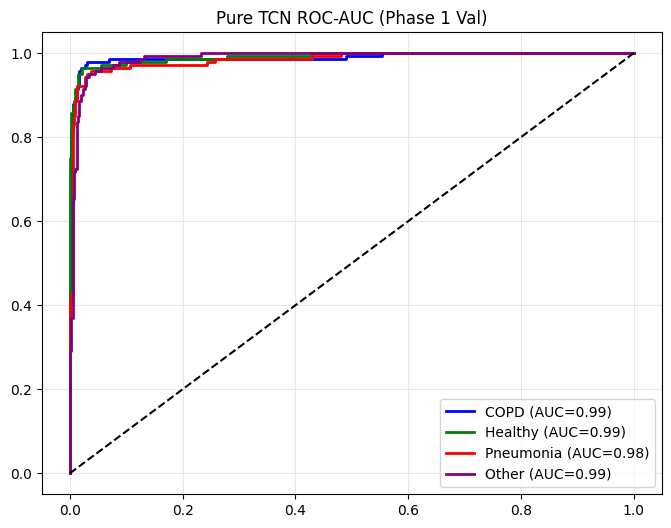

              precision    recall  f1-score   support

        COPD       0.96      0.90      0.93       140
     Healthy       0.97      0.91      0.94       141
   Pneumonia       0.90      0.94      0.92       140
       Other       0.89      0.96      0.92       141

    accuracy                           0.93       562
   macro avg       0.93      0.93      0.93       562
weighted avg       0.93      0.93      0.93       562


Generating Grad-CAM Explainer for Pure TCN (Phase 1)...


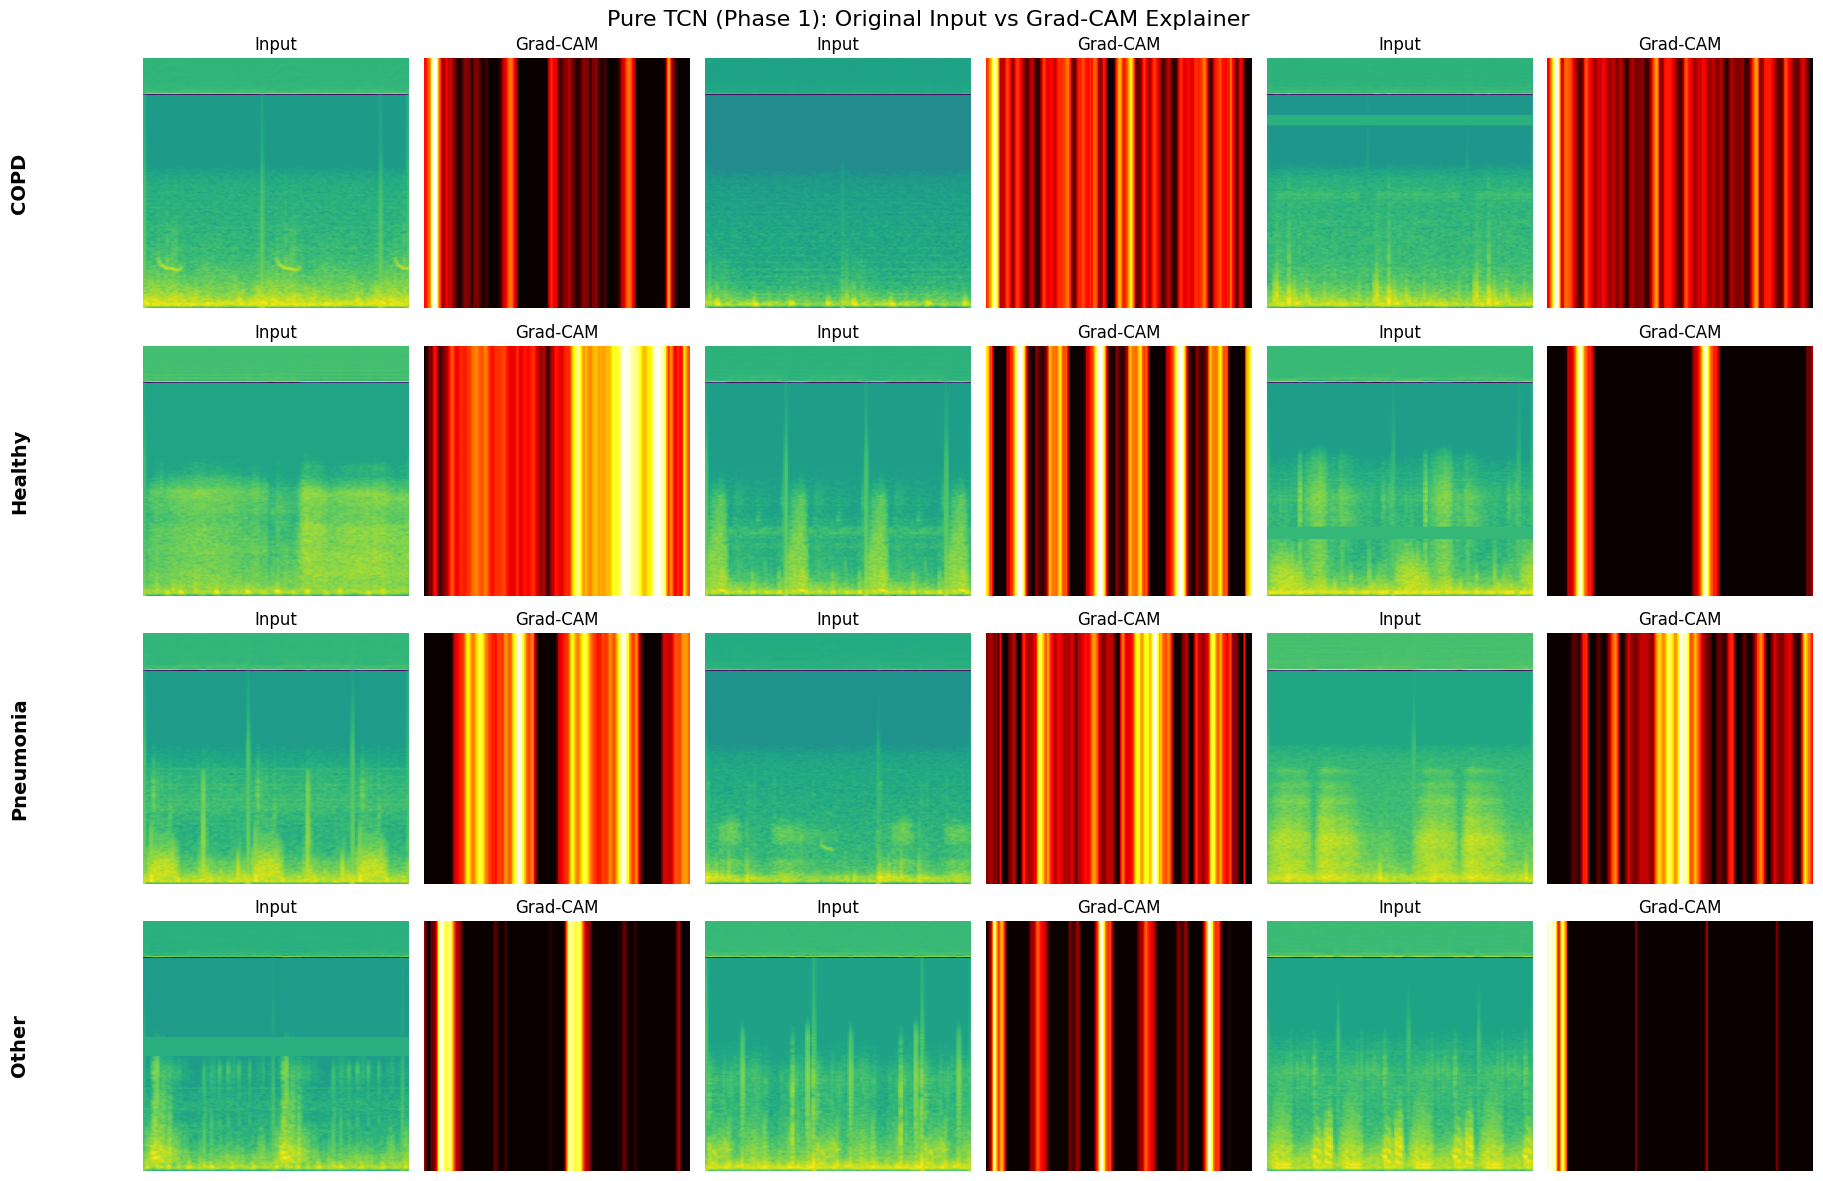

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



==================== Processing: LSTM ====================

[Model Architecture: LSTM]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_LSTM       │  978 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 978 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 978 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.



>>> LSTM Finished | Time: 369.12s | Best Val Acc: 0.8274


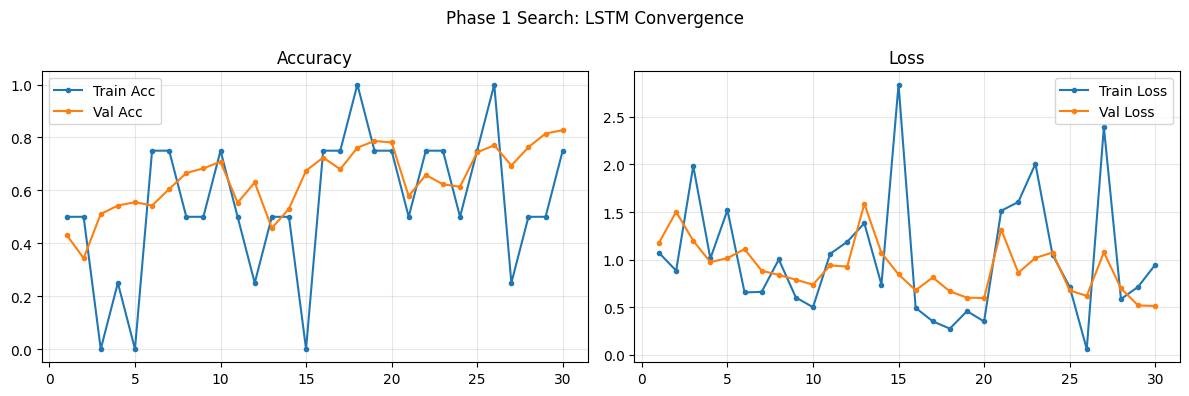


==================== LSTM EVALUATION (Phase 1 Val) ====================


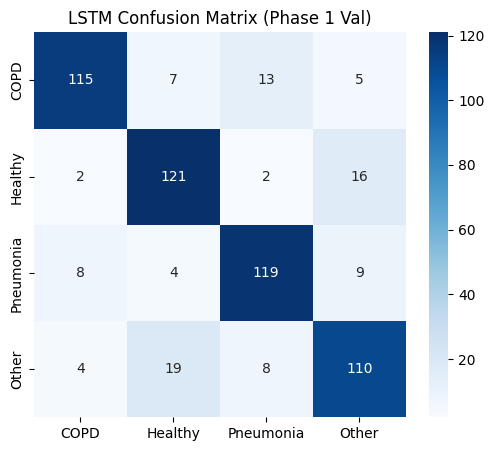

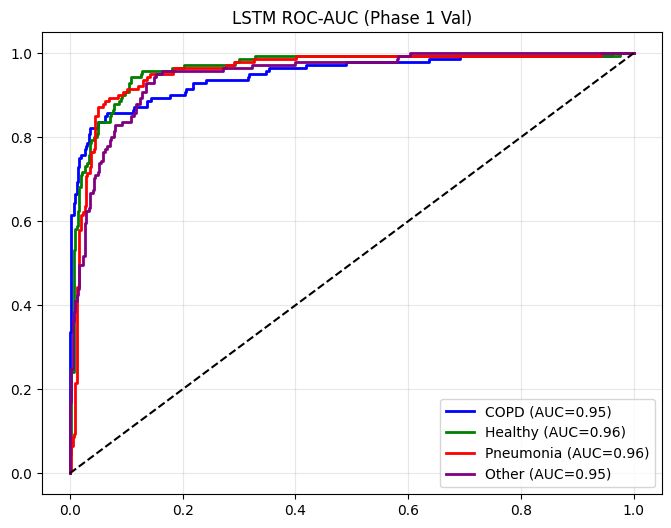

              precision    recall  f1-score   support

        COPD       0.89      0.82      0.86       140
     Healthy       0.80      0.86      0.83       141
   Pneumonia       0.84      0.85      0.84       140
       Other       0.79      0.78      0.78       141

    accuracy                           0.83       562
   macro avg       0.83      0.83      0.83       562
weighted avg       0.83      0.83      0.83       562


Generating Grad-CAM Explainer for LSTM (Phase 1)...


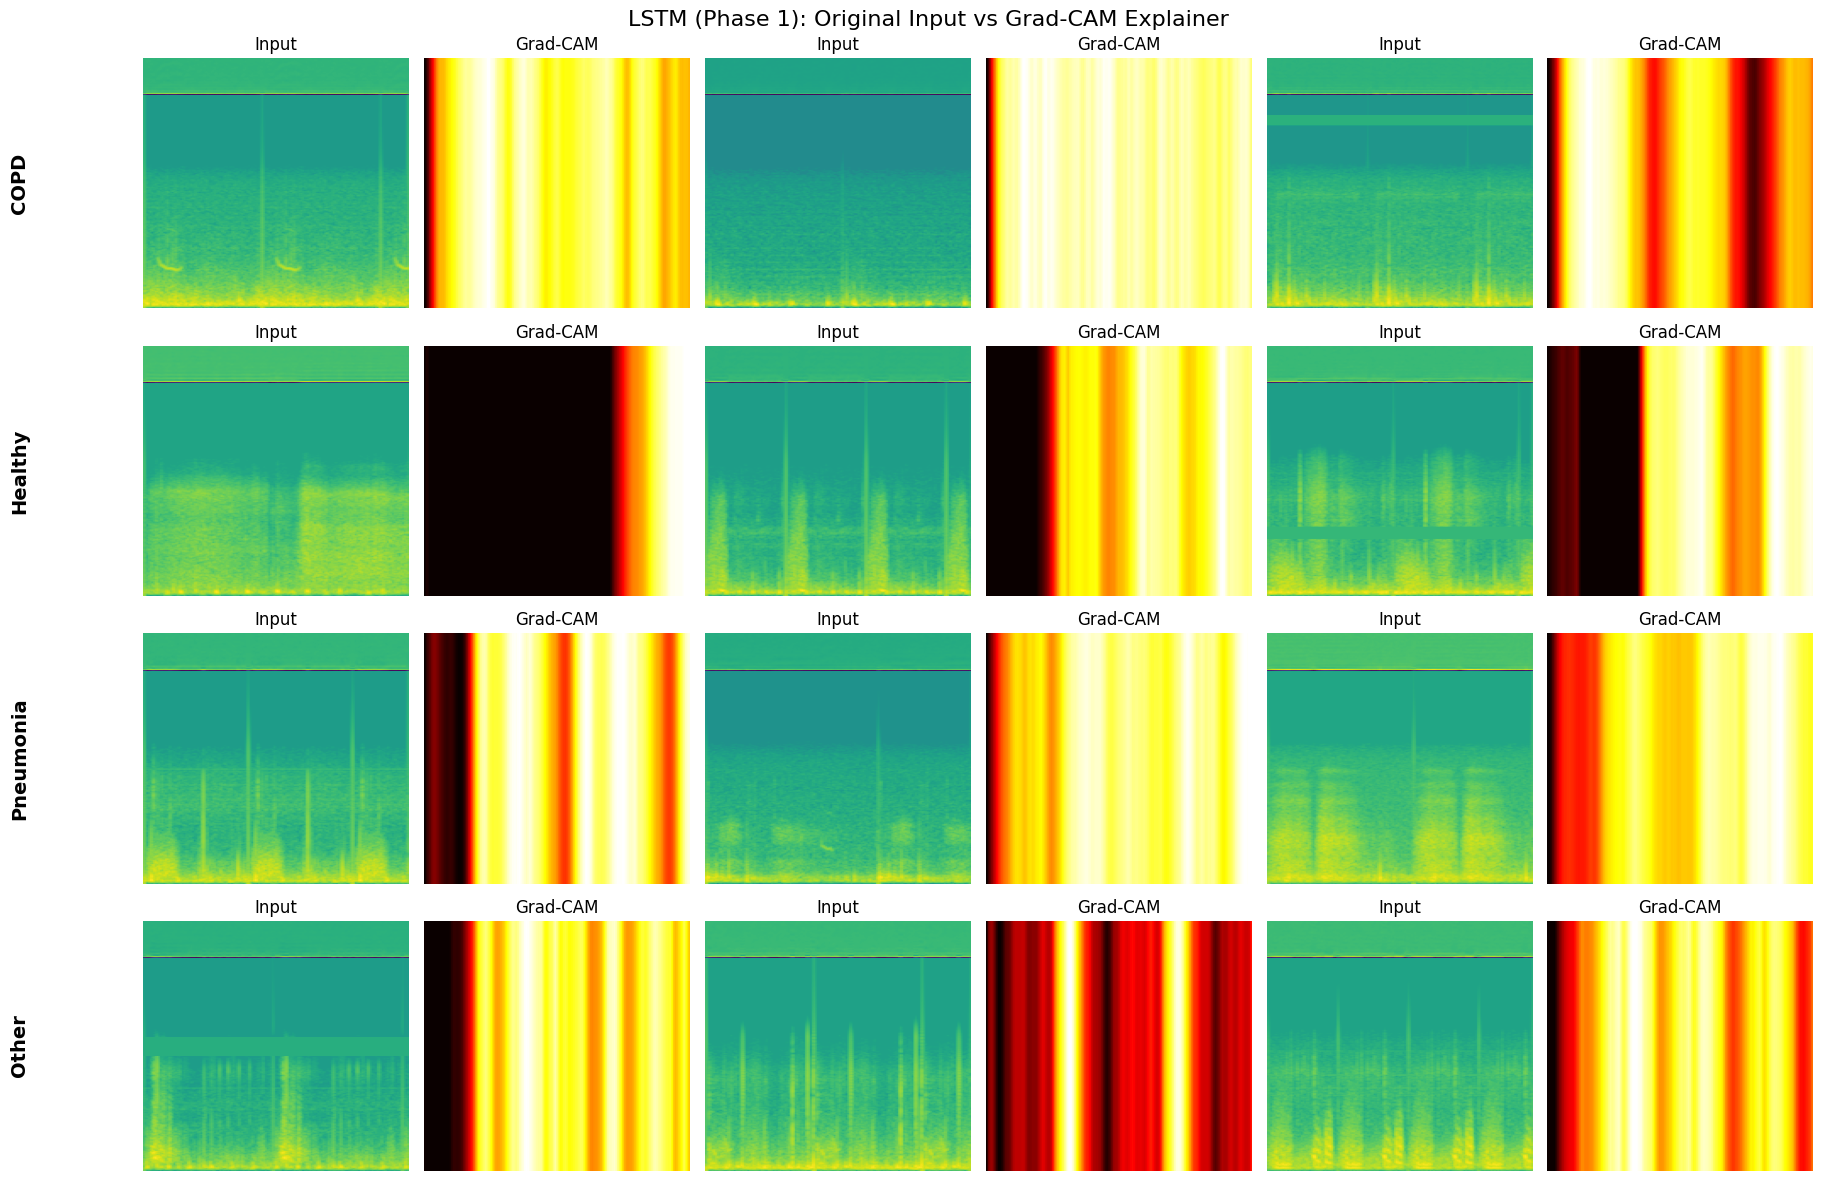

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



==================== Processing: Vanilla RNN ====================

[Model Architecture: Vanilla RNN]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Vanilla_RNN │  269 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss  │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 269 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 269 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.



>>> Vanilla RNN Finished | Time: 385.29s | Best Val Acc: 0.6512


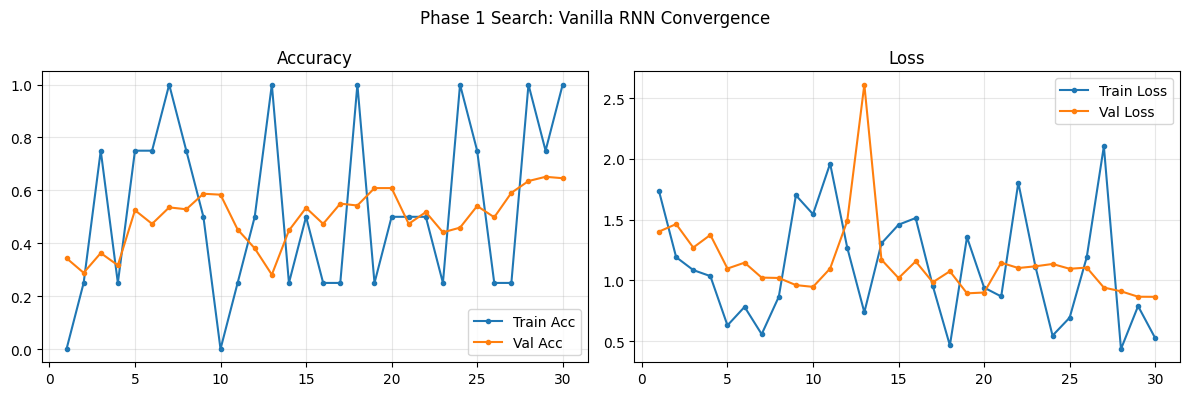


==================== Vanilla RNN EVALUATION (Phase 1 Val) ====================


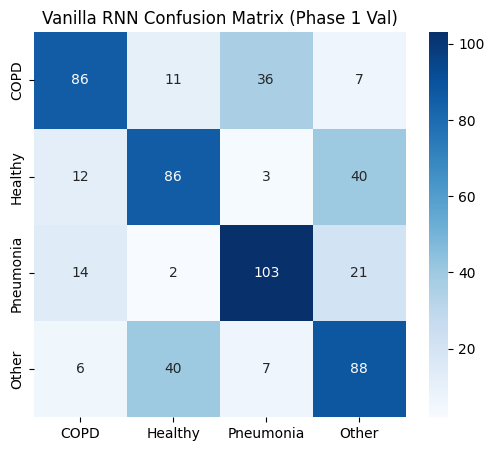

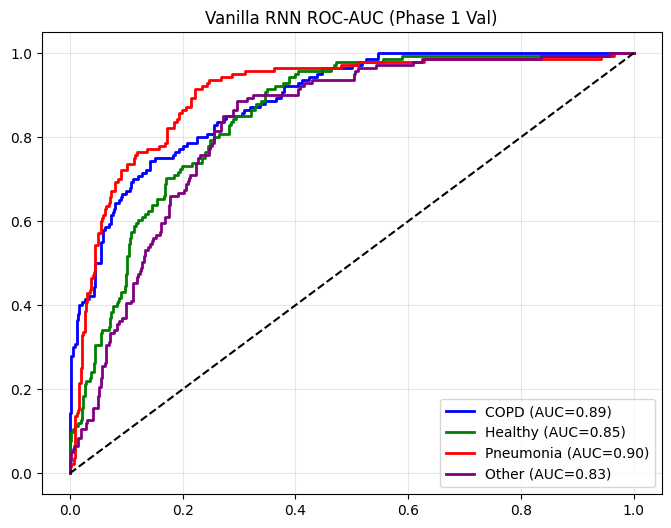

              precision    recall  f1-score   support

        COPD       0.73      0.61      0.67       140
     Healthy       0.62      0.61      0.61       141
   Pneumonia       0.69      0.74      0.71       140
       Other       0.56      0.62      0.59       141

    accuracy                           0.65       562
   macro avg       0.65      0.65      0.65       562
weighted avg       0.65      0.65      0.65       562


Generating Grad-CAM Explainer for Vanilla RNN (Phase 1)...


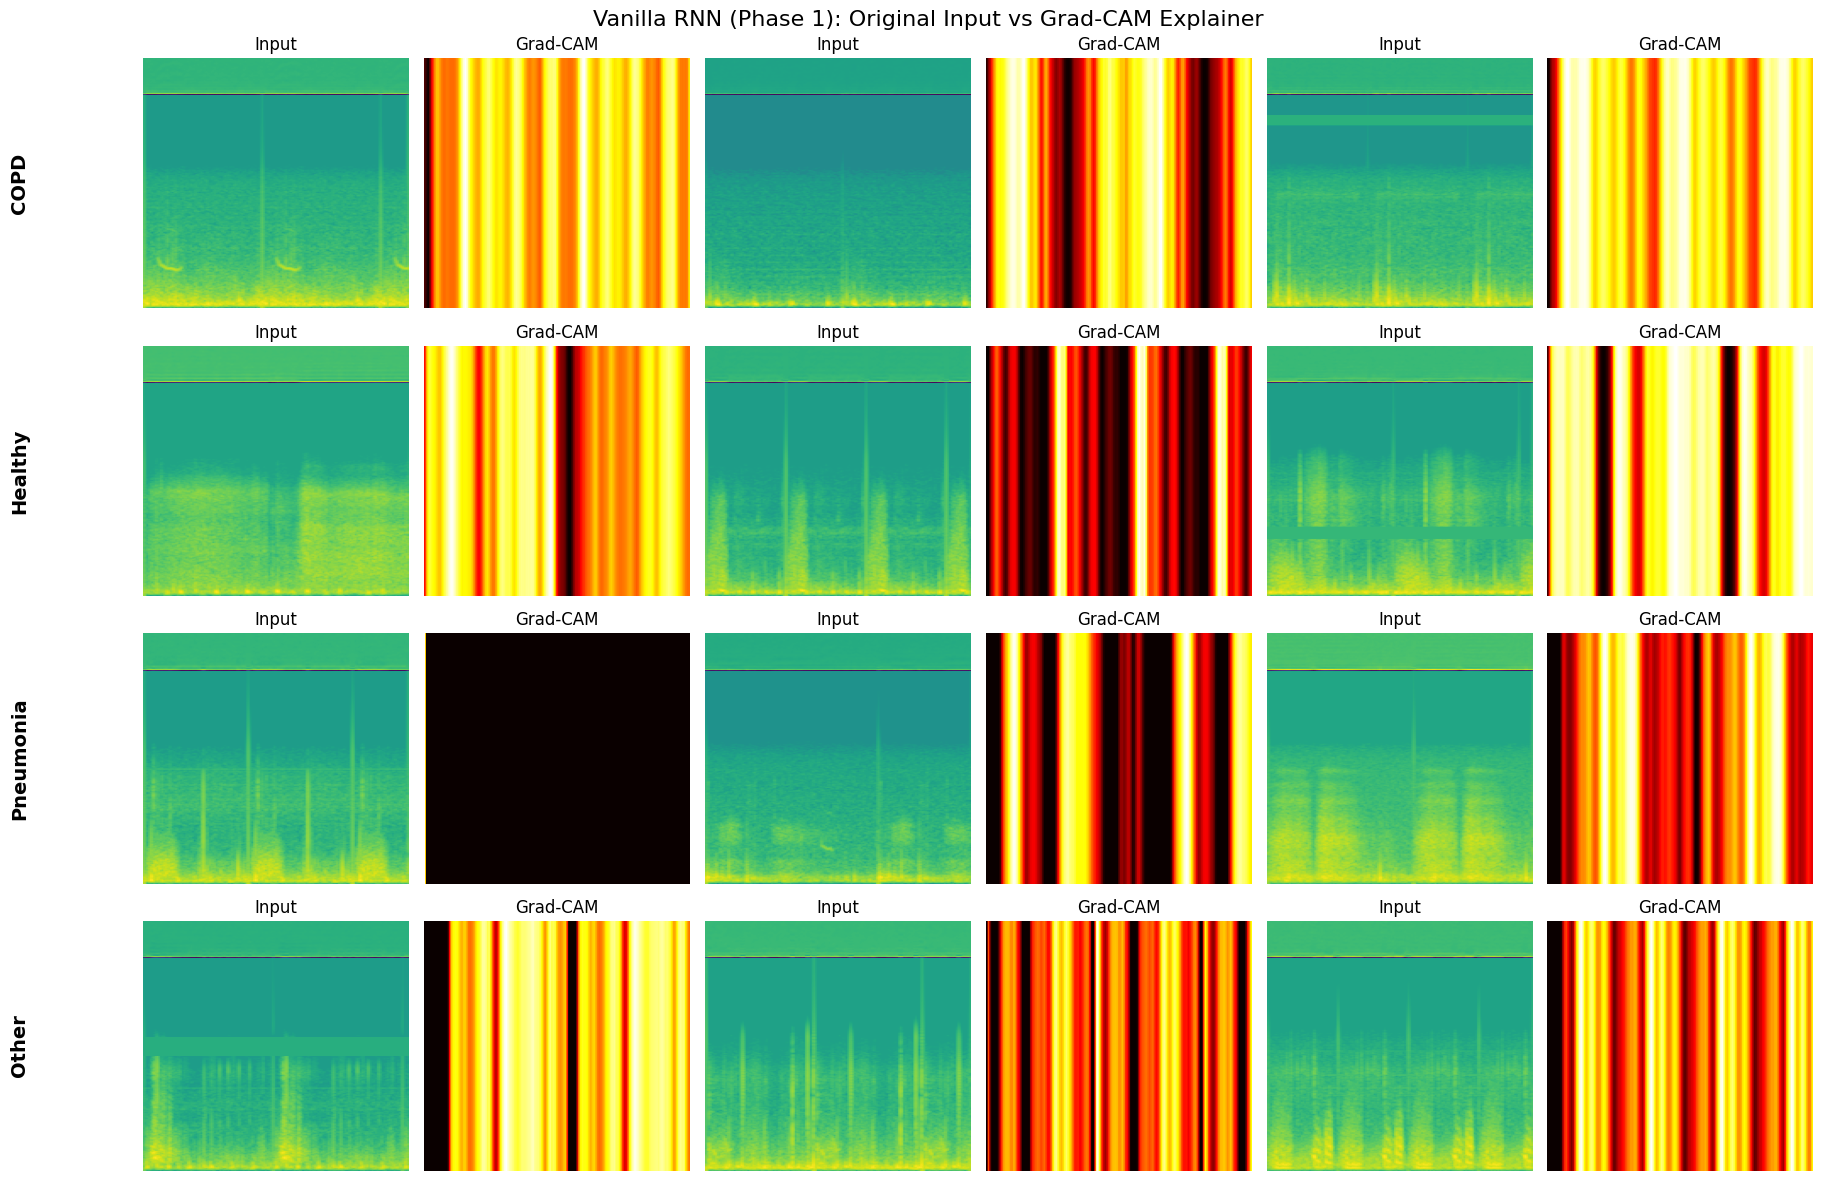


🏆 TOP 2 CANDIDATES: ['Pure TCN', 'TCN-SNN']


******************** OPTIMIZING TOP CANDIDATE: Pure TCN ********************

--------------------------------------------------
PHASE 2: GRID SEARCH TUNING (Pure TCN)
--------------------------------------------------
Total Combinations to Test: 12


Tuning Pure TCN:   0%|          | 0/12 [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


   [New Best] Trial 1: Acc=0.9075 | Config={'BATCH_SIZE': 16, 'LR': 0.0005, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.0, 'DROPOUT': 0.15, 'HIDDEN_DIM': 192}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


   [New Best] Trial 5: Acc=0.9164 | Config={'BATCH_SIZE': 16, 'LR': 0.0005, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.1, 'DROPOUT': 0.2, 'HIDDEN_DIM': 192}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


   [New Best] Trial 7: Acc=0.9288 | Config={'BATCH_SIZE': 16, 'LR': 0.001, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.0, 'DROPOUT': 0.15, 'HIDDEN_DIM': 192}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Best HPs for Pure TCN: {'BATCH_SIZE': 16, 'LR': 0.001, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.0, 'DROPOUT': 0.15, 'HIDDEN_DIM': 192}

--------------------------------------------------
PHASE 3: FINAL TRAINING (Pure TCN + Best HPs)
--------------------------------------------------


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_Pure_TCN   │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



******************** OPTIMIZING TOP CANDIDATE: TCN-SNN ********************

--------------------------------------------------
PHASE 2: GRID SEARCH TUNING (TCN-SNN)
--------------------------------------------------
Total Combinations to Test: 12


Tuning TCN-SNN:   0%|          | 0/12 [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


   [New Best] Trial 1: Acc=0.9039 | Config={'BATCH_SIZE': 16, 'LR': 0.0005, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.0, 'DROPOUT': 0.15, 'HIDDEN_DIM': 192}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


   [New Best] Trial 3: Acc=0.9110 | Config={'BATCH_SIZE': 16, 'LR': 0.0005, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.0, 'DROPOUT': 0.25, 'HIDDEN_DIM': 192}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


   [New Best] Trial 5: Acc=0.9128 | Config={'BATCH_SIZE': 16, 'LR': 0.0005, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.1, 'DROPOUT': 0.2, 'HIDDEN_DIM': 192}


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


   [New Best] Trial 8: Acc=0.9181 | Config={'BATCH_SIZE': 16, 'LR': 0.001, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.0, 'DROPOUT': 0.2, 'HIDDEN_DIM': 192}


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_epochs=10` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


✅ Best HPs for TCN-SNN: {'BATCH_SIZE': 16, 'LR': 0.001, 'WEIGHT_DECAY': 0.0001, 'OPTIMIZER': 'AdamW', 'LABEL_SMOOTHING': 0.0, 'DROPOUT': 0.2, 'HIDDEN_DIM': 192}

--------------------------------------------------
PHASE 3: FINAL TRAINING (TCN-SNN + Best HPs)
--------------------------------------------------


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Model_TCN_SNN    │  708 K │ train │     0 │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │     0 │
└───┴─────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 708 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 708 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.



############################## VISUALIZING FINAL MODEL: Pure TCN ##############################


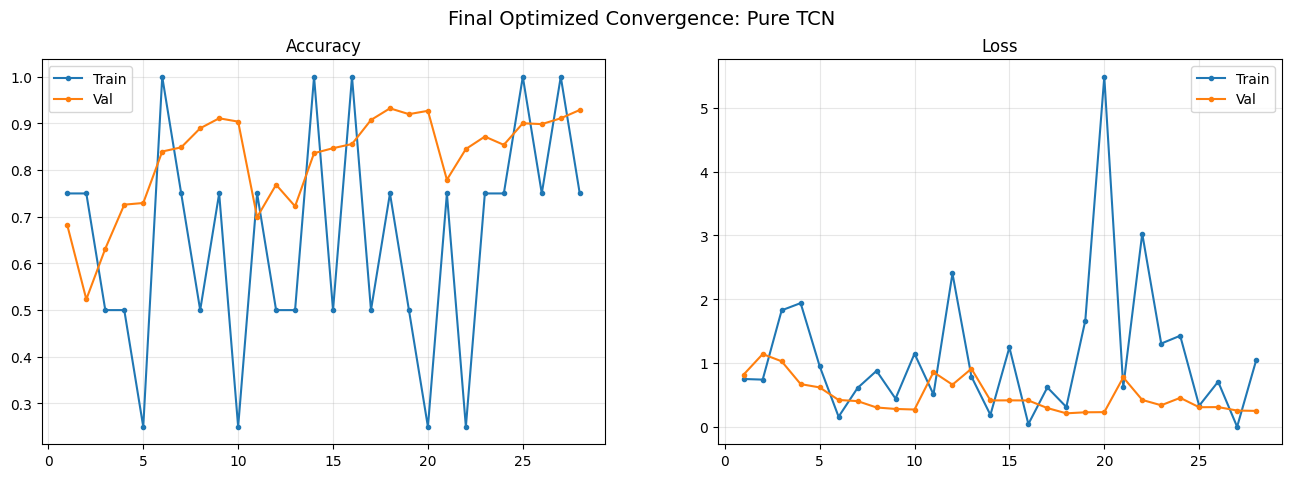


==================== Pure TCN EVALUATION (Final Test Optimized) ====================


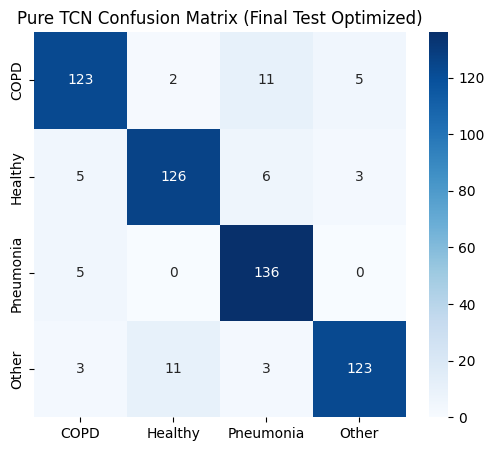

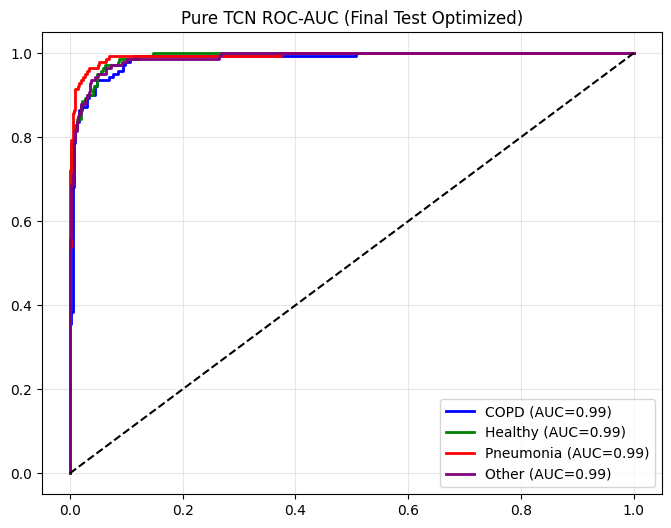

              precision    recall  f1-score   support

        COPD       0.90      0.87      0.89       141
     Healthy       0.91      0.90      0.90       140
   Pneumonia       0.87      0.96      0.92       141
       Other       0.94      0.88      0.91       140

    accuracy                           0.90       562
   macro avg       0.91      0.90      0.90       562
weighted avg       0.91      0.90      0.90       562


Generating Grad-CAM Explainer for Pure TCN (Final Optimized)...


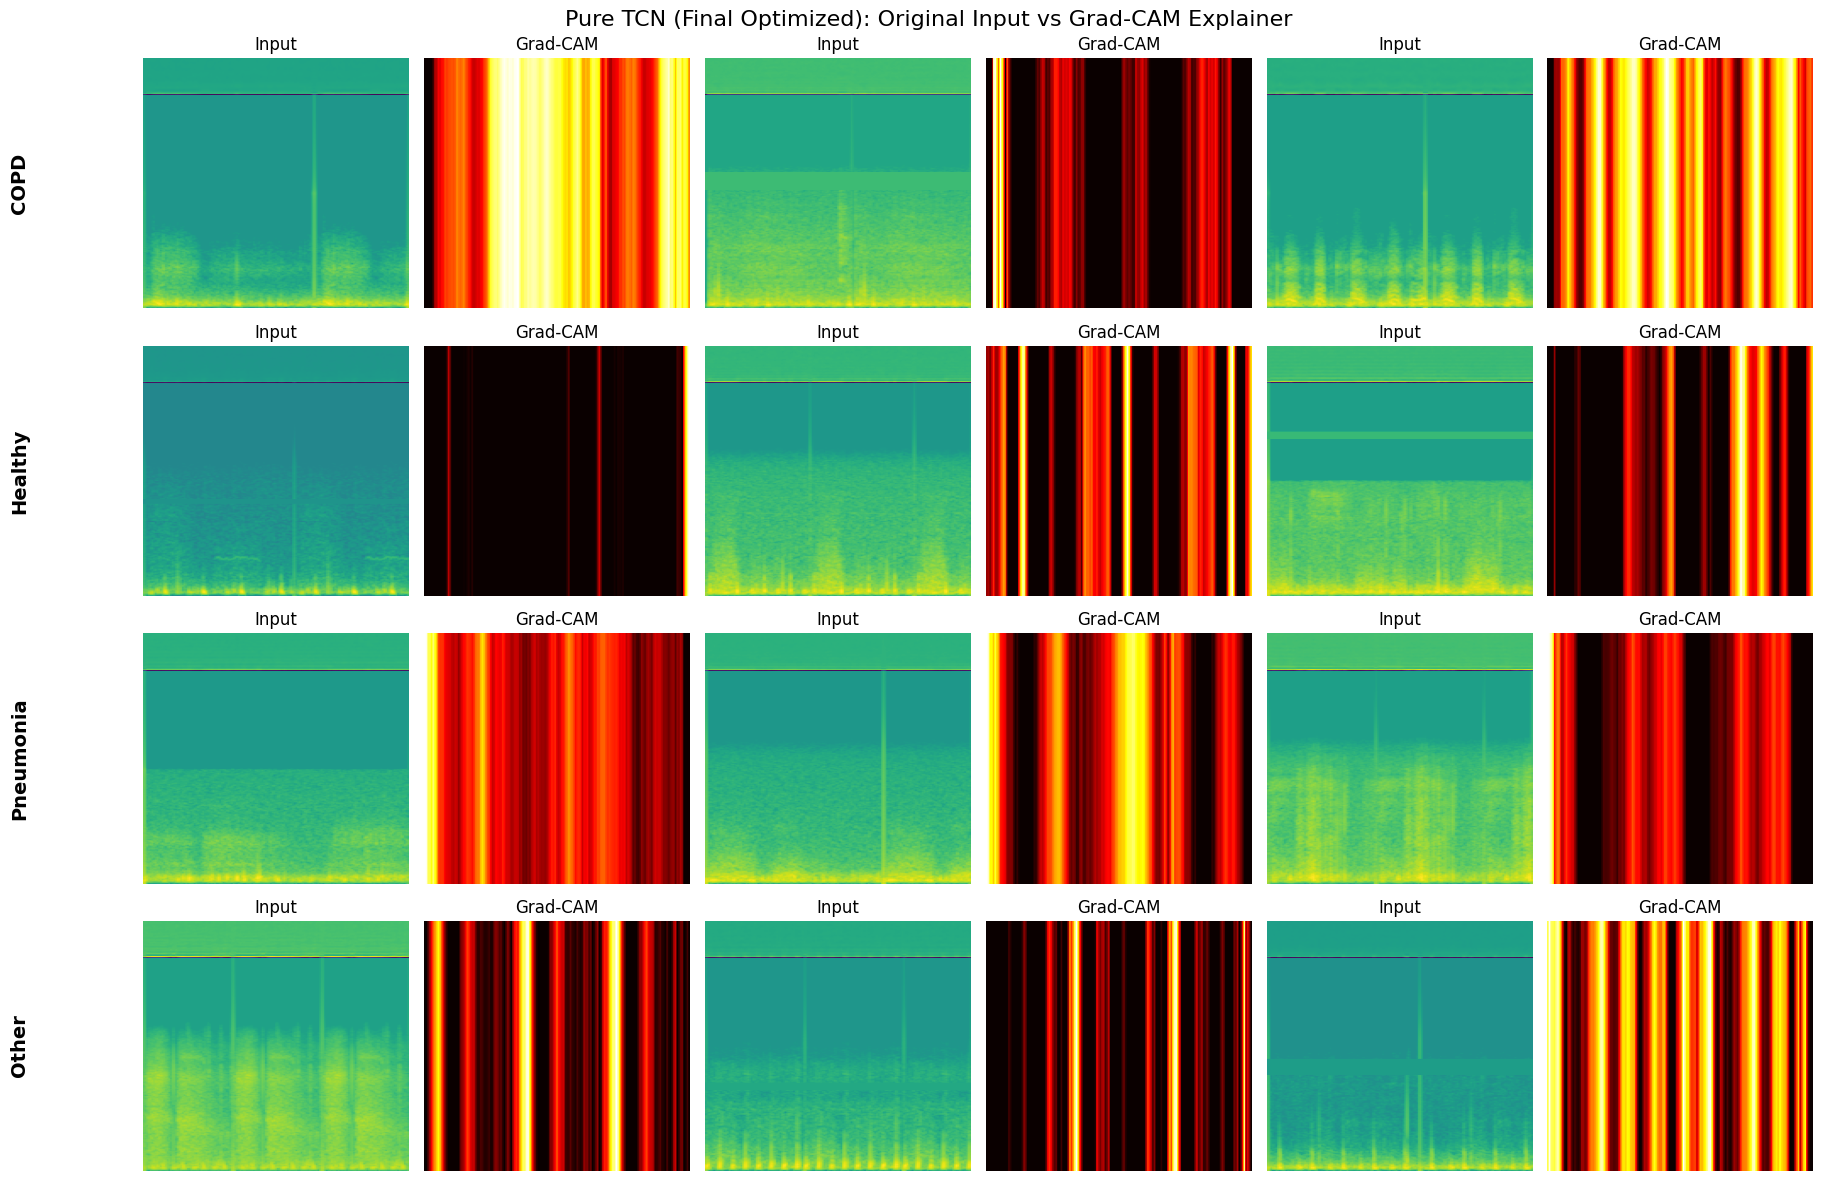


############################## VISUALIZING FINAL MODEL: TCN-SNN ##############################


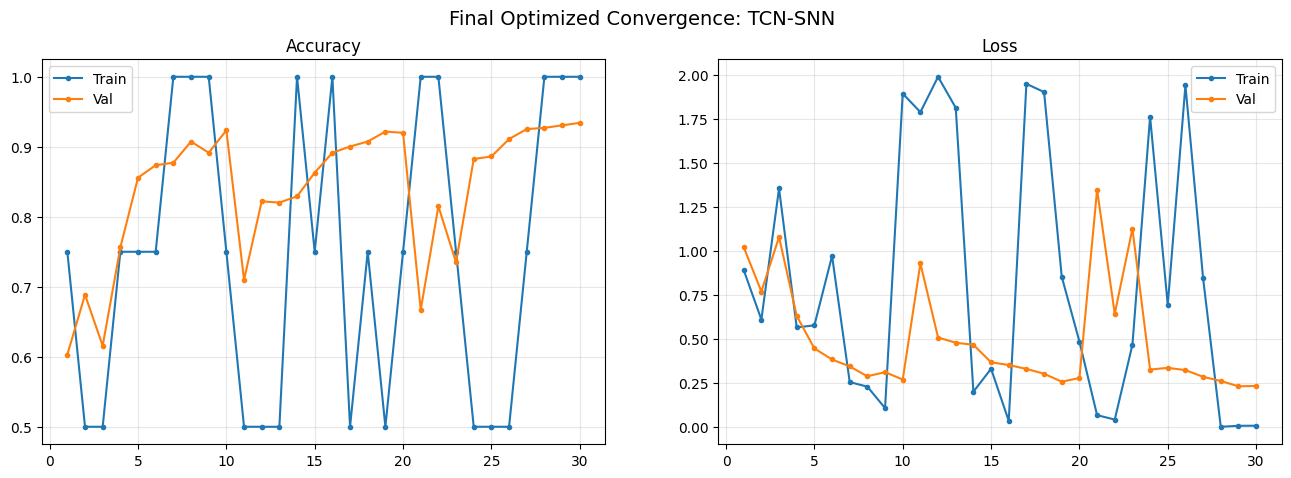


==================== TCN-SNN EVALUATION (Final Test Optimized) ====================


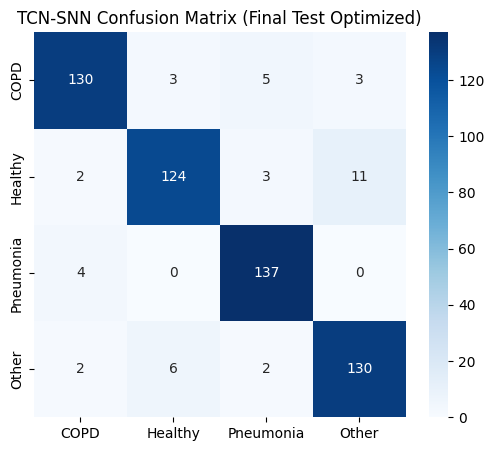

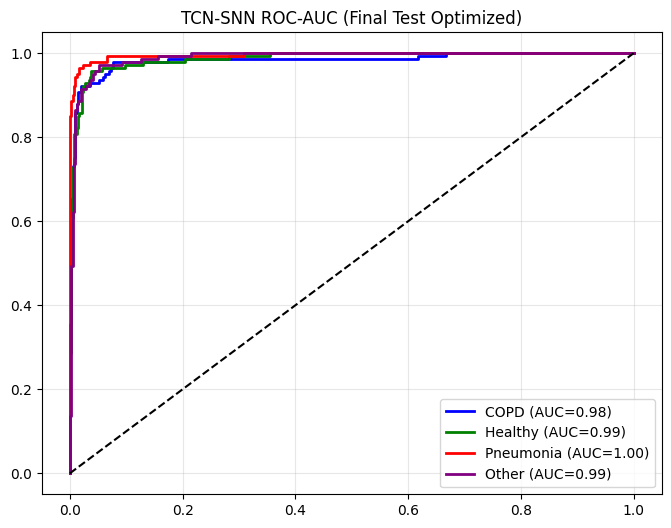

              precision    recall  f1-score   support

        COPD       0.94      0.92      0.93       141
     Healthy       0.93      0.89      0.91       140
   Pneumonia       0.93      0.97      0.95       141
       Other       0.90      0.93      0.92       140

    accuracy                           0.93       562
   macro avg       0.93      0.93      0.93       562
weighted avg       0.93      0.93      0.93       562


Generating Grad-CAM Explainer for TCN-SNN (Final Optimized)...


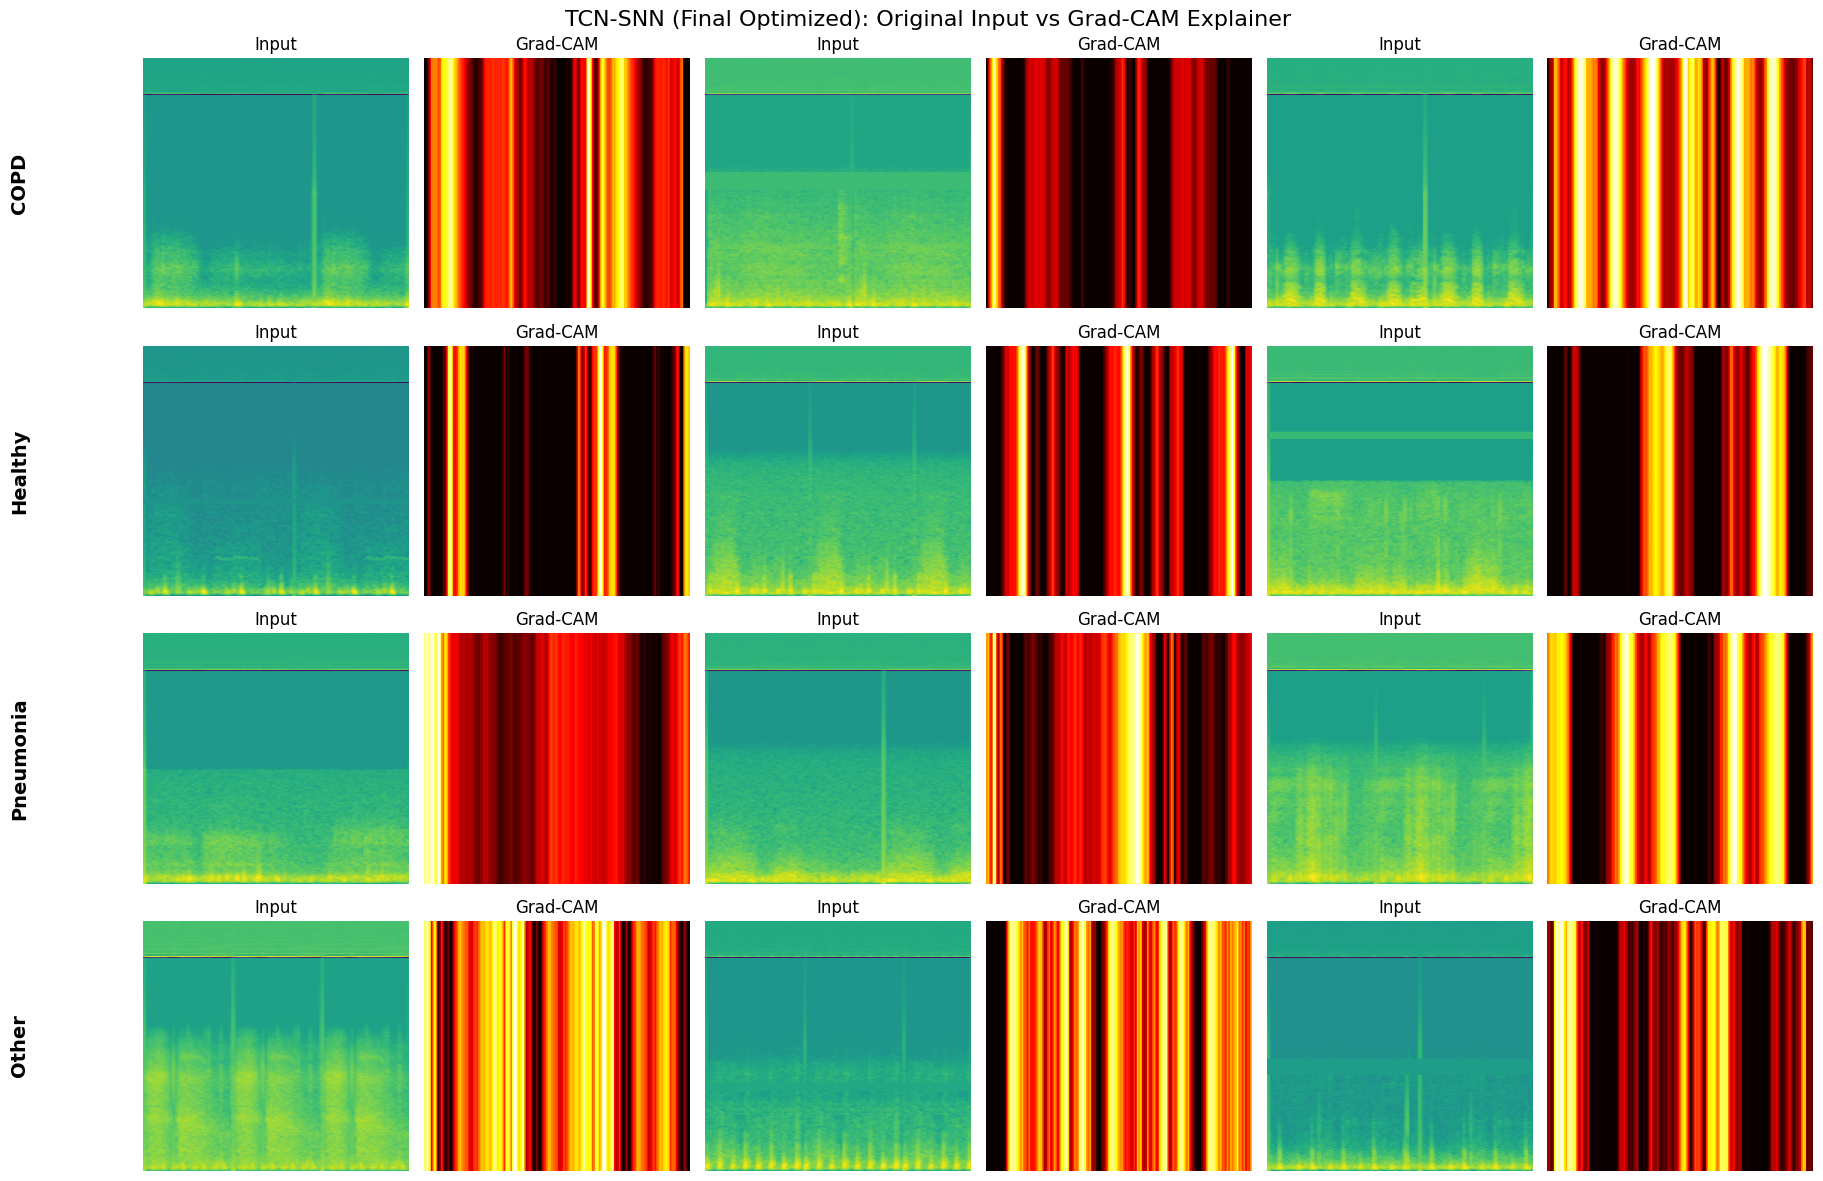

In [ ]:
# ================= EXECUTION =================
if __name__ == "__main__":
    print("--- Loading Data ---")
    icbhi_root = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")
    cv_root = kagglehub.dataset_download("rudhirmahalik/class-cv-lungs")

    ICBHI_PATH = ""
    for root, dirs, files in os.walk(icbhi_root):
        if "audio_and_txt_files" in dirs: ICBHI_PATH = os.path.join(root, "audio_and_txt_files")
        if "patient_diagnosis.csv" in files: DIAG_FILE = os.path.join(root, "patient_diagnosis.csv")
    
    diag_df = pd.read_csv(DIAG_FILE, names=["patient_id", "disease"])
    diag_df["disease"] = diag_df["disease"].map(DISEASE_MAPPING)
    diag_df = diag_df[diag_df.disease.isin(TARGET_CLASSES)]
    
    full_meta = []
    for txt in glob.glob(os.path.join(ICBHI_PATH, "*.txt")):
        pid = int(os.path.basename(txt).split("_")[0])
        if pid in diag_df.patient_id.values:
            d_name = diag_df[diag_df.patient_id == pid].disease.values[0]
            wav = txt.replace(".txt", ".wav")
            if os.path.exists(wav):
                try:
                    df = pd.read_csv(txt, sep="\t", header=None, names=["s", "e", "c", "w"])
                    for _, r in df.iterrows():
                        if r["e"]-r["s"] > 0.4:
                            full_meta.append({"path": wav, "s": r["s"], "dur": r["e"]-r["s"], "label": LABEL_MAP[d_name]})
                except: pass

    for root, dirs, files in os.walk(cv_root):
        lid = None
        fn = os.path.basename(root).lower()
        if "copd" in fn: lid = LABEL_MAP["COPD"]
        elif "healthy" in fn: lid = LABEL_MAP["Healthy"]
        elif "pneumonia" in fn: lid = LABEL_MAP["Pneumonia"]
        elif "asthma" in fn or "covid" in fn or "bronchi" in fn: lid = LABEL_MAP["Other"]
        if lid is not None:
            for f in files:
                if f.endswith('.wav'): full_meta.append({"path": os.path.join(root, f), "s": 0, "dur": None, "label": lid})

    random.shuffle(full_meta)
    print("--- Extracting Features ---")
    data_map = {0: [], 1: [], 2: [], 3: []}
    for item in tqdm(full_meta):
        feat = get_features(item["path"], item["s"], item["dur"])
        if feat is not None: data_map[item["label"]].append(feat)

    print("--- [3/6] Balancing Data ---")
    valid_counts = [len(v) for v in data_map.values() if len(v) > 0]
    min_count = min(valid_counts)
    X_final, y_final = [], []
    for lbl in range(len(TARGET_CLASSES)): 
        if len(data_map[lbl]) == 0: continue
        orig = random.sample(data_map[lbl], min_count)
        aug = [augment_spectrogram(s) for s in orig]
        combined = orig + aug
        X_final.extend(combined); y_final.extend([lbl]*len(combined))
    
    X_final = np.array(X_final); y_final = np.array(y_final)
    print(f"Final Balanced Shape: {X_final.shape} (2x {min_count} per class)")
    plot_class_distribution([np.sum(y_final==i) for i in range(4)], "Balanced Data")

    X_train, X_temp, y_train, y_temp = train_test_split(X_final, y_final, test_size=0.40, stratify=y_final, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)

    models = {
        "TCN-SNN": Model_TCN_SNN, "Pure TCN": Model_Pure_TCN,
        "LSTM": Model_LSTM, "Vanilla RNN": Model_Vanilla_RNN
    }
    
    top_2_names = run_phase_1_architecture_search(models, X_train, y_train, X_val, y_val)
    
    # Pre-select fixed samples from Test Set for Final Explainer (Apples-to-Apples)
    test_loader_for_samples = DataLoader(AudioDataset(X_test, y_test), batch_size=16)
    fixed_test_samples = select_fixed_samples(test_loader_for_samples)
    
    final_results_list = []
    for winner in top_2_names:
        print(f"\n\n{'*'*20} OPTIMIZING TOP CANDIDATE: {winner} {'*'*20}")
        best_hp = run_phase_2_tuning(winner, models[winner], X_train, y_train, X_val, y_val)
        res = run_phase_3_final_train(winner, models[winner], best_hp, X_train, y_train, X_val, y_val, X_test, y_test)
        final_results_list.append(res)
    
    visualize_final_results_list(final_results_list, fixed_test_samples)

In [ ]:


    # ================= 4. SAVE MODELS FOR DEPLOYMENT =================
print("\n" + "="*50)
print("SAVING TOP 2 MODELS FOR DEPLOYMENT")
print("="*50)

import json

    # Create directory
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

for res in final_results_list:
        model_name = res['name']
        model_state = res['model'].state_dict()
        best_hp = res['hp']

        # Create filenames
        safe_name = model_name.replace(" ", "_").replace("-", "_").lower()
        model_path = os.path.join(save_dir, f"{safe_name}_weights.pth")
        config_path = os.path.join(save_dir, f"{safe_name}_config.json")

        # 1. Save State Dict (Weights)
        torch.save(model_state, model_path)

        # 2. Save Configuration (Metadata needed to rebuild model in Streamlit)
        deployment_config = {
            "architecture": model_name,
            "n_classes": len(TARGET_CLASSES),
            "labels": TARGET_CLASSES,
            "audio_settings": {
                "sample_rate": DEFAULT_CONFIG["SAMPLE_RATE"],
                "duration": DEFAULT_CONFIG["DURATION"],
                "n_mels": DEFAULT_CONFIG["N_MELS"],
                "n_mfcc": DEFAULT_CONFIG["N_MFCC"],
                "n_fft": DEFAULT_CONFIG["N_FFT"],
                "hop_length": DEFAULT_CONFIG["HOP_LENGTH"],
                "total_input_channels": TOTAL_INPUT_CHANNELS
            },
            "model_hyperparameters": {
                "hidden_dim": best_hp["HIDDEN_DIM"],
                "dropout": best_hp["DROPOUT"],
                "input_channels": TOTAL_INPUT_CHANNELS
            }
        }

        with open(config_path, 'w') as f:
            json.dump(deployment_config, f, indent=4)

        print(f"Saved {model_name}:")
        print(f"   - Weights: {model_path}")
        print(f"   - Config:  {config_path}")

print("\n>>> Pipeline Complete. Models are ready for Streamlit!")


SAVING TOP 2 MODELS FOR DEPLOYMENT
✅ Saved Pure TCN:
   - Weights: saved_models\pure_tcn_weights.pth
   - Config:  saved_models\pure_tcn_config.json
✅ Saved TCN-SNN:
   - Weights: saved_models\tcn_snn_weights.pth
   - Config:  saved_models\tcn_snn_config.json

>>> Pipeline Complete. Models are ready for Streamlit!
